# Label Quality Scores for Regression with Noisy Labels
In this tutorial, you will learn how to use cleanlab on regression dataset to: 
- find label issue in your regression dataset
- generate label quality scores for each example in the dataset. 

## Install dependencies and import them 
You can use pip to install all packages required for this tutorial as follows:

In [ ]:
!pip install cleanlab
!pip install scikit-learn

In [1]:
import numpy as np 
import pandas as pd 
from cleanlab.regression.rank import get_label_quality_scores
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 

In [21]:
def make_data(feature_size = (20, 2), 
    means = [8, -10], 
    stds = [2, 5], 
    bias = 0.8,
    coeff = [2, 0.1],
    error = [-2, 0, 2], 
    prob_error = [0.2, 0.6, 0.2],  
    seed = 42
) -> pd.DataFrame:
    """
    feature_size: Tuple of (datapoints, features)
    """
    assert (len(means) == feature_size[1]), (f"length of mean {len(means)} is not same as features requested{feature_size[0]}")
    assert (len(stds) == feature_size[1]), (f"length of stds {len(stds)} is not same as features requested{feature_size[0]}")
    np.random.seed(seed)    

    features = []
    for i in range(feature_size[1]):
        values = coeff[i] * np.random.normal(loc=means[i], scale=stds[i], size=feature_size[0])
        features.append(values)
    
    true_labels = sum(map(np.array, features))+ bias
    labels = true_labels + np.random.choice(error, feature_size[0], p=prob_error)
    
    data_dict = {
                "labels"      : labels,      # You have these labels, which have some errors.
                "true_labels" : true_labels, # You never get to see these perfect labels.
                }    
    for idx, feature in enumerate(features): # adding names to each features 
        data_dict["feature_"+str(idx+1)] = feature
    data = pd.DataFrame.from_dict(data_dict)
    col = list(data.columns)
    new_col = col[2:] + col[:2]
    data = data.reindex(columns=new_col)
    return data

def plot_data(data, 
                circles, 
                title, 
                alpha=0.6, 
                color = '#1f77b4', 
                colorbar = False):
    
    plt.figure(figsize=(14, 5))
    data = data.to_numpy()
    plt.scatter(data[:,0], data[:,1], c = color, s=60)
    for i in circles:
        plt.plot(
            data[i][0],
            data[i][1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=alpha
        )
    plt.title(title, fontsize=20)
    
    if colorbar: plt.colorbar(orientation = 'vertical')


In [22]:
path = "/Users/krmayank/Desktop/Work/cleanlab/experiments/student_score_regression.csv"
data = pd.read_csv(path, index_col=0)
data.head()

,exam_1,exam_2,exam_3,bonus_or_penalty,true_labels,labels
0,53,77,93,0,76.2,56.2
1,81,64,80,10,85.5,65.5
2,74,88,97,0,87.4,67.4
3,61,94,78,0,77.7,57.7
4,48,90,91,0,77.8,77.8


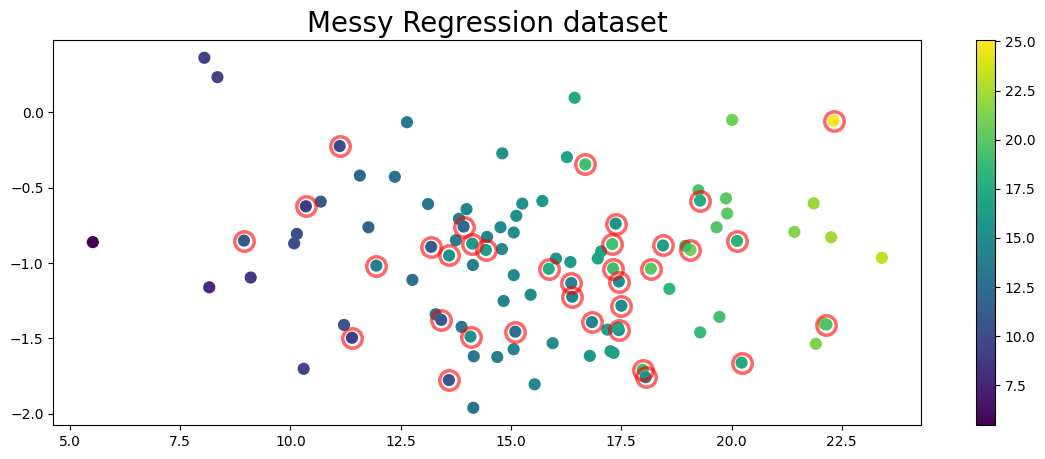

In [23]:
data = make_data(feature_size=(100, 2))
true_errors = np.where(data['true_labels'] != data['labels'])[0]
plot_data(data[['feature_1','feature_2']], 
            circles=true_errors, 
            color=data['labels'], 
            colorbar=True, 
            title="Messy Regression dataset")

The figure above represents a toy dataset we'll use to demonstrate label scoring for regression dataset. In this example, datapoints are ploted on 2-D space (in this case feature_1 vs feature_2). Each datapoint is colored based on given label. 

Like many real-world datasets, the given label happen to be incorrect for some of the examples(**circled in red**) in this dataset. 

## Using cleanlab to generate label quality scores

In [24]:
# start with checking the dataset generated
data.head()

,feature_1,feature_2,labels,true_labels
0,17.986857,-1.707685,19.079171,17.079171
1,15.446943,-1.210323,15.036620,15.036620
2,18.590754,-1.171357,18.219397,18.219397
3,22.092119,-1.401139,21.490981,21.490981
4,15.063387,-1.080643,14.782744,14.782744


In [25]:
# Note that "true_labels" will not be available in real-life dataset. We have added here only for comparision.
X = data[['feature_'+str(i+1) for i in range(2)]]
y = data['labels']

# initialize your favourite model and generate predictions 
yourFavouriteModel = LinearRegression()
yourFavouriteModel = yourFavouriteModel.fit(X,y)
predictions = yourFavouriteModel.predict(X)

# get label quality score for each example in the dataset 
label_quality = get_label_quality_scores(labels=np.array(data['labels']), pred_labels=predictions)

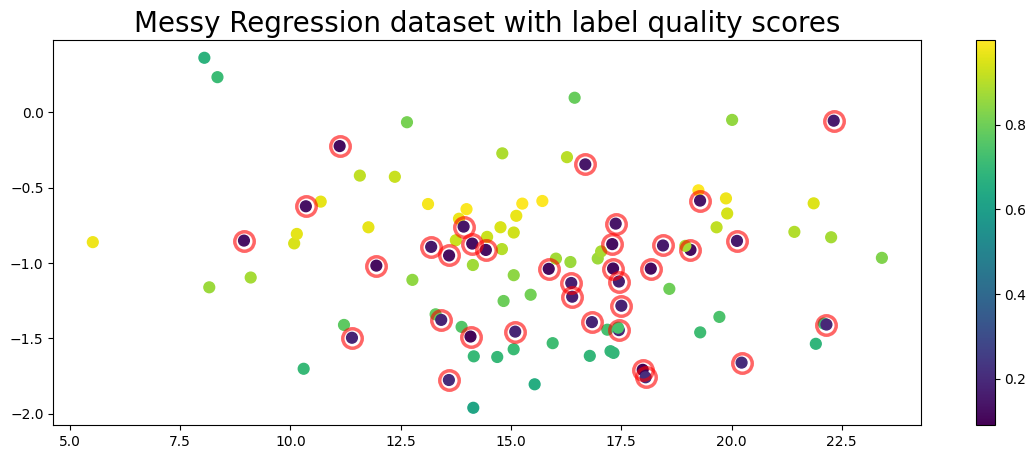

In [26]:
plot_data(
    data[['feature_1','feature_2']], 
    circles=true_errors ,
    color=label_quality, 
    title="Messy Regression dataset with label quality scores", 
    colorbar=True)

In the above plot, we have colored each datapoint considering its label quality score. \
Datapoints in the plot are same as earlier plot in the notebook. \
**Red circle** represents that these datapoint were incorrectly marked when compared to true_label. 

Low scores for datapoints marked in **Red circle** and High scores for other datapoints justifies that method can identify the errors in the dataset. 